In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# Add project root to path
sys.path.append('.')

from src.data.data_loader import load_data_with_validation
from src.training.metrics import compute_confusion_matrix, print_classification_report
from src.utils.visualisation import plot_confusion_matrix, plot_model_comparison
from src.utils.config import *

# Settings
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Imports successful!")

Imports successful!


In [2]:
import os 

# You can verify the new directory
print(f"Current Working Directory: {os.getcwd()}")

print("Loading data...")
_, _, X_test, _, _, y_test, loader = load_data_with_validation()

print(f"    Test set: {len(X_test)} samples")
print(f"    Features: {X_test.shape[1]}")
print(f"    Genres: {GENRES}")

Current Working Directory: C:\Users\ShriyaAsija\music-genre-classification\notebooks
Loading data...
Data loaded with train, validation, and test sets.
    Test set: 200 samples
    Features: 40
    Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
# Load all models
def load_all_models():
    models = {}
    
    # Scratch models
    scratch_dir = Path('../models/scratch')
    if scratch_dir.exists():
        for model_file in scratch_dir.glob('*.pkl'):
            name = model_file.stem.replace('_', ' ').title()
            data = joblib.load(model_file)
            models[f"Scratch-{name}"] = data
    
    # Sklearn models
    sklearn_dir = Path('../models/sklearn')
    if sklearn_dir.exists():
        for model_file in sklearn_dir.glob('*.joblib'):
            name = model_file.stem.replace('_', ' ').title()
            data = joblib.load(model_file)
            models[f"Sklearn-{name}"] = data
    
    return models

models = load_all_models()
print(f"Loaded {len(models)} models")
print("\nModels:")
for name in models.keys():
    print(f"  • {name}")

Loaded 9 models

Models:
  • Scratch-Decision Tree
  • Scratch-Knn
  • Scratch-Logistic Regression
  • Sklearn-Decision Tree Model
  • Sklearn-Gradient Boosting Model
  • Sklearn-Knn Model
  • Sklearn-Logistic Regression Model
  • Sklearn-Random Forest Model
  • Sklearn-Svm Model


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

results = {}
print("--- Starting Model Evaluation on Test Set ---")

for name, model_or_dict in models.items():
    print("\n" + "="*50)
    print(f"Evaluating: {name}")

    if isinstance(model_or_dict, dict):
        actual_model = model_or_dict['model']
    else:
        actual_model = model_or_dict

    y_pred = actual_model.predict(X_test)
    
    report_dict = classification_report(y_test, y_pred, target_names=GENRES, output_dict=True, zero_division=0)
    
    results[name] = report_dict
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=GENRES, zero_division=0))

    macro_avg = report_dict['macro avg']
    
    results[name] = {
        'accuracy': report_dict['accuracy'],
        'precision': macro_avg['precision'],
        'recall': macro_avg['recall'],
        'f1': macro_avg['f1-score'] 
    }
    
    print(f"--> Accuracy for {name}: {report_dict['accuracy']:.4f}")
    print("="*50)

print("\nEvaluation complete!")

--- Starting Model Evaluation on Test Set ---

Evaluating: Scratch-Decision Tree
Classification Report:
              precision    recall  f1-score   support

       blues       0.41      0.35      0.38        20
   classical       0.87      0.65      0.74        20
     country       0.40      0.40      0.40        20
       disco       0.42      0.40      0.41        20
      hiphop       0.42      0.40      0.41        20
        jazz       0.46      0.65      0.54        20
       metal       0.83      0.75      0.79        20
         pop       0.65      0.65      0.65        20
      reggae       0.37      0.35      0.36        20
        rock       0.20      0.25      0.22        20

    accuracy                           0.48       200
   macro avg       0.50      0.48      0.49       200
weighted avg       0.50      0.48      0.49       200

--> Accuracy for Scratch-Decision Tree: 0.4850

Evaluating: Scratch-Knn
Classification Report:
              precision    recall  f1-scor

In [36]:
results_df = pd.DataFrame(results).T  

results_df = results_df[['accuracy', 'precision', 'recall', 'f1']]

results_df = results_df.sort_values('accuracy', ascending=False)

print(results_df.round(4))

                                   accuracy  precision  recall      f1
Sklearn-Svm Model                     0.690     0.6965   0.690  0.6862
Sklearn-Logistic Regression Model     0.680     0.6653   0.680  0.6642
Sklearn-Random Forest Model           0.655     0.6476   0.655  0.6478
Scratch-Knn                           0.635     0.6637   0.635  0.6365
Sklearn-Gradient Boosting Model       0.625     0.6484   0.625  0.6323
Sklearn-Knn Model                     0.585     0.6051   0.585  0.5821
Scratch-Decision Tree                 0.485     0.5037   0.485  0.4904
Sklearn-Decision Tree Model           0.445     0.4546   0.445  0.4471
Scratch-Logistic Regression           0.355     0.3036   0.355  0.2841


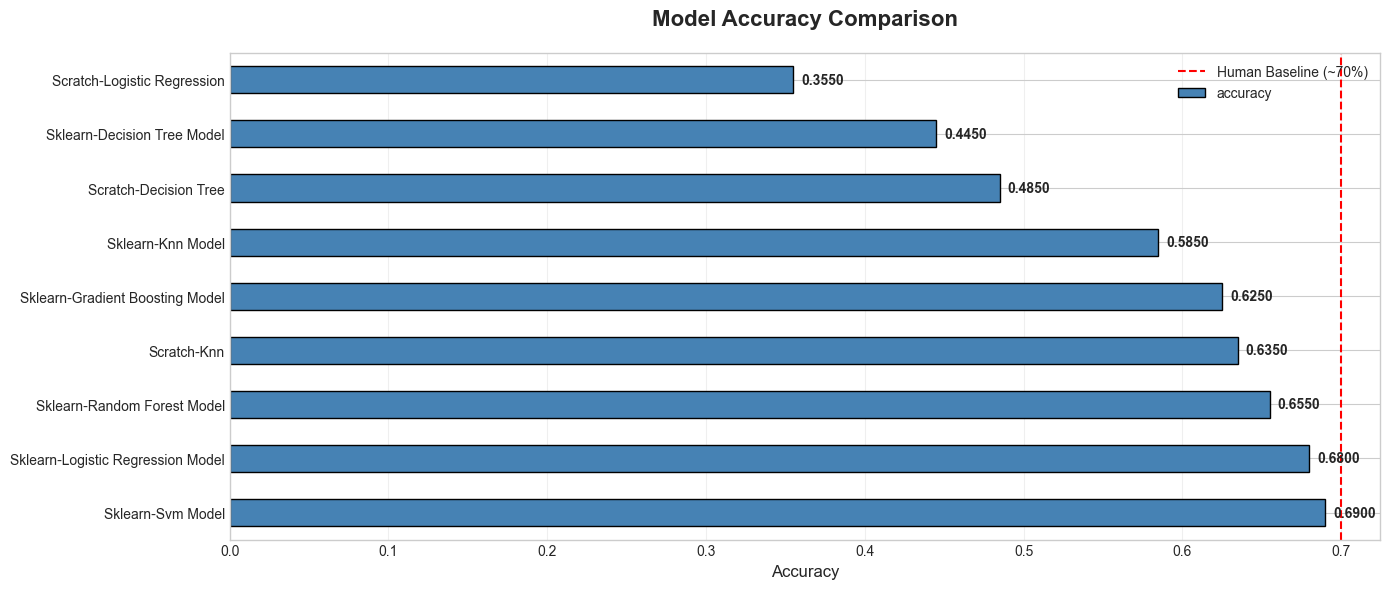

Best Model: Sklearn-Svm Model with 0.6900 accuracy


In [37]:
fig, ax = plt.subplots(figsize=(14, 6))

results_df['accuracy'].plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')

ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
ax.axvline(0.70, color='red', linestyle='--', label='Human Baseline (~70%)')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add values on bars
for i, v in enumerate(results_df['accuracy']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Best Model: {results_df.index[0]} with {results_df['accuracy'].iloc[0]:.4f} accuracy")

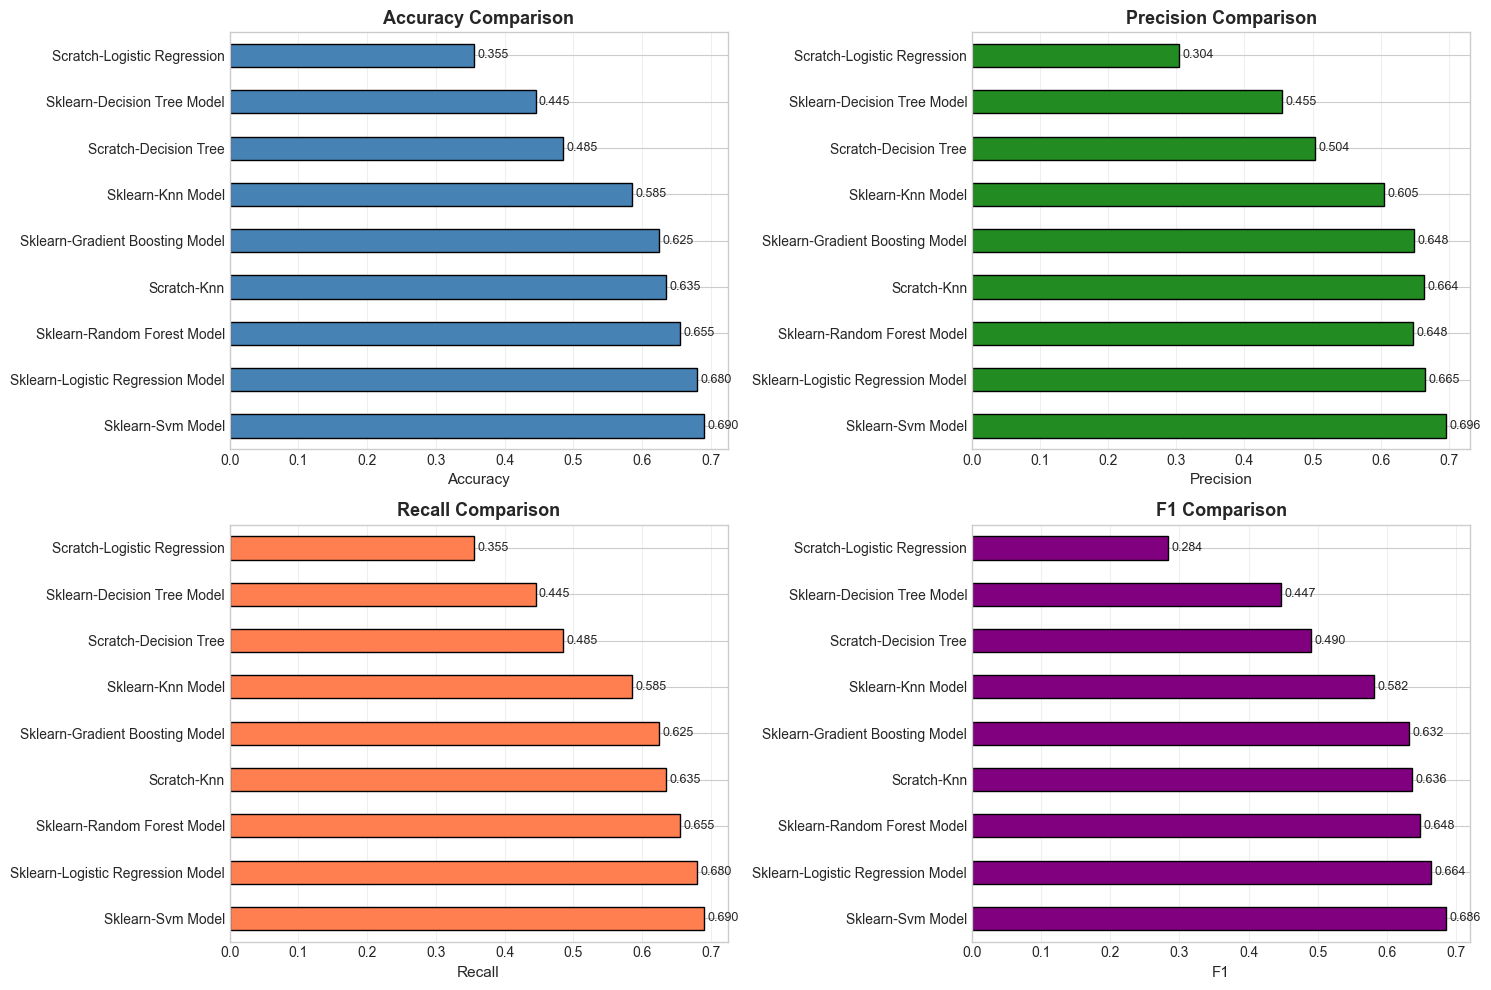

In [38]:
# Multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['steelblue', 'forestgreen', 'coral', 'purple']

for ax, metric, color in zip(axes.flat, metrics, colors):
    results_df[metric].plot(kind='barh', ax=ax, color=color, edgecolor='black')
    ax.set_xlabel(metric.capitalize(), fontsize=11)
    ax.set_title(f'{metric.capitalize()} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add values
    for i, v in enumerate(results_df[metric]):
        ax.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

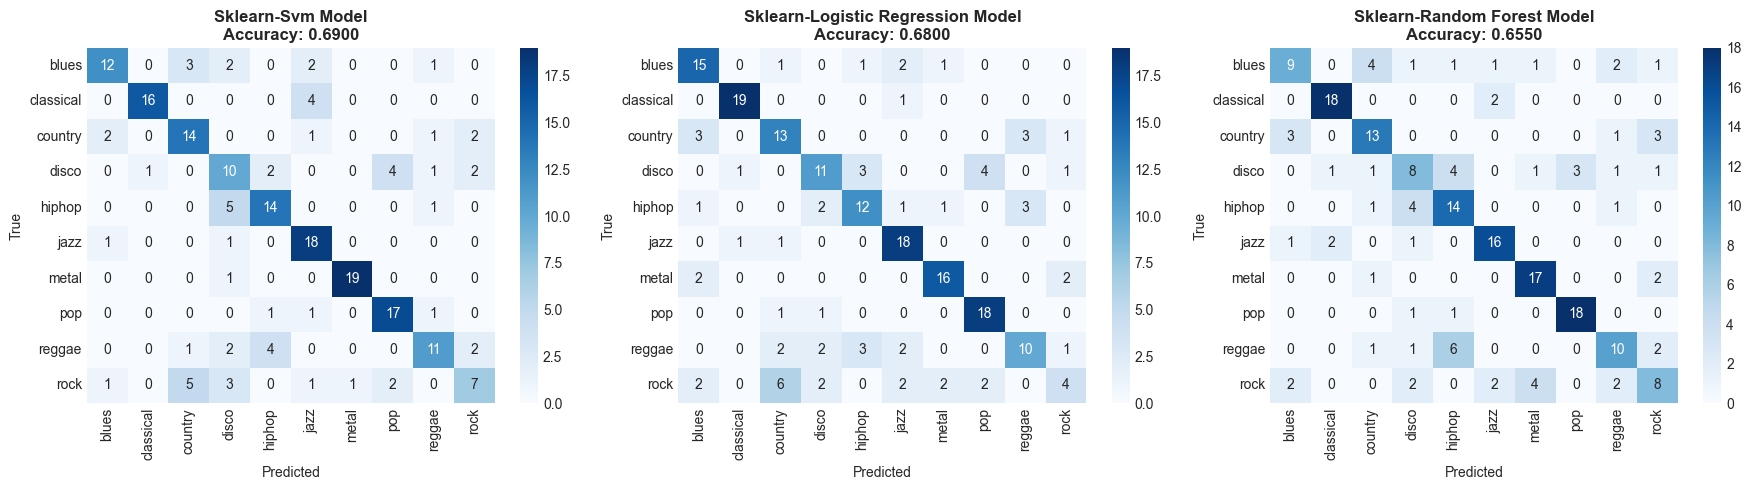

In [39]:
# Show confusion matrices for top 3 models
top_3_models = results_df.index[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model_name in zip(axes, top_3_models):
    model = models[model_name]
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=GENRES, yticklabels=GENRES)
    
    ax.set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

In [40]:
# Best model's genre-wise performance
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

print(f"Genre-wise Performance for {best_model_name}:\n")
print(classification_report(y_test, y_pred, target_names=GENRES))

Genre-wise Performance for Sklearn-Svm Model:

              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        20
   classical       0.94      0.80      0.86        20
     country       0.61      0.70      0.65        20
       disco       0.42      0.50      0.45        20
      hiphop       0.67      0.70      0.68        20
        jazz       0.67      0.90      0.77        20
       metal       0.95      0.95      0.95        20
         pop       0.74      0.85      0.79        20
      reggae       0.69      0.55      0.61        20
        rock       0.54      0.35      0.42        20

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.69      0.69       200



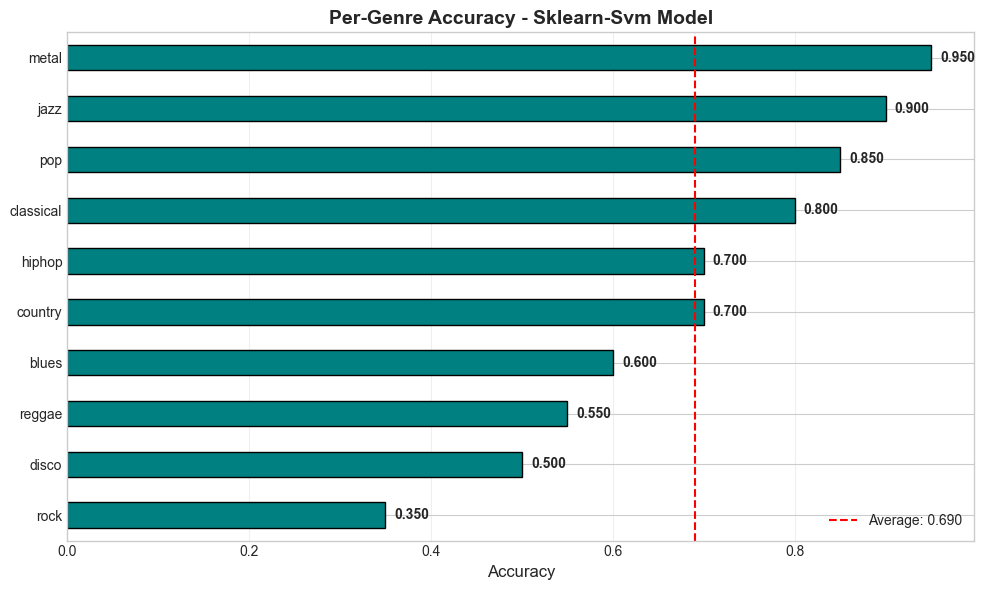


Best classified genre: metal (0.950)
Worst classified genre: rock (0.350)


In [41]:
# Genre accuracy comparison
from sklearn.metrics import accuracy_score

genre_accuracies = {}

for genre_idx, genre_name in enumerate(GENRES):
    # Get samples for this genre
    genre_mask = y_test == genre_idx
    
    if np.sum(genre_mask) > 0:
        y_pred_best = best_model.predict(X_test[genre_mask])
        acc = accuracy_score(y_test[genre_mask], y_pred_best)
        genre_accuracies[genre_name] = acc

# Plot
genre_df = pd.Series(genre_accuracies).sort_values()

plt.figure(figsize=(10, 6))
genre_df.plot(kind='barh', color='teal', edgecolor='black')
plt.xlabel('Accuracy', fontsize=12)
plt.title(f'Per-Genre Accuracy - {best_model_name}', fontsize=14, fontweight='bold')
plt.axvline(genre_df.mean(), color='red', linestyle='--', label=f'Average: {genre_df.mean():.3f}')
plt.legend()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(genre_df):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nBest classified genre: {genre_df.idxmax()} ({genre_df.max():.3f})")
print(f"Worst classified genre: {genre_df.idxmin()} ({genre_df.min():.3f})")